## Time Series Tasks
### Part 1

In [2]:
#Setup
import pandas as pd
from datetime import datetime, timedelta
from scipy import stats
import numpy as np
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm
baseline_dat = pd.read_csv('patient_baseline.csv', sep="\t")
long_dat = pd.read_csv('patient_longitudinal.csv', sep="\t")
treat_dat = pd.read_csv('patient_treatment.csv', sep="\t")

In [4]:
##checking to see which rows in long_dat are duplicates and missing values, if any
duplicates = long_dat.duplicated()
print(duplicates)
missing_per_col = long_dat.isna().sum()
print(missing_per_col)
##subset of long_dat data frame
bp_long_dat = long_dat[['visit_date', 'bp_systolic']]
##converting visit_date column to correct datetime format
dates = pd.to_datetime(bp_long_dat['visit_date'], format='%Y-%m-%d')
#creating a pandas time series of BP measurements
ts_bp = pd.Series(data=bp_long_dat['bp_systolic'].values, index=dates)
print(ts_bp)

0       False
1       False
2       False
3       False
4       False
        ...  
3995    False
3996    False
3997    False
3998    False
3999    False
Length: 4000, dtype: bool
patient_id       0
visit_date       0
bp_systolic      0
heart_rate       0
adverse_event    0
age              0
sex              0
bmi              0
smoking          0
diabetes         0
dtype: int64
visit_date
2023-01-17    111.0
2023-09-23    112.0
2024-05-22    111.2
2024-12-31    109.2
2023-01-17    146.1
              ...  
2024-12-31    136.9
2023-01-17    140.5
2023-09-23    140.2
2024-05-22    139.6
2024-12-31    138.5
Length: 4000, dtype: float64


## 2. Blood Pressure Trends

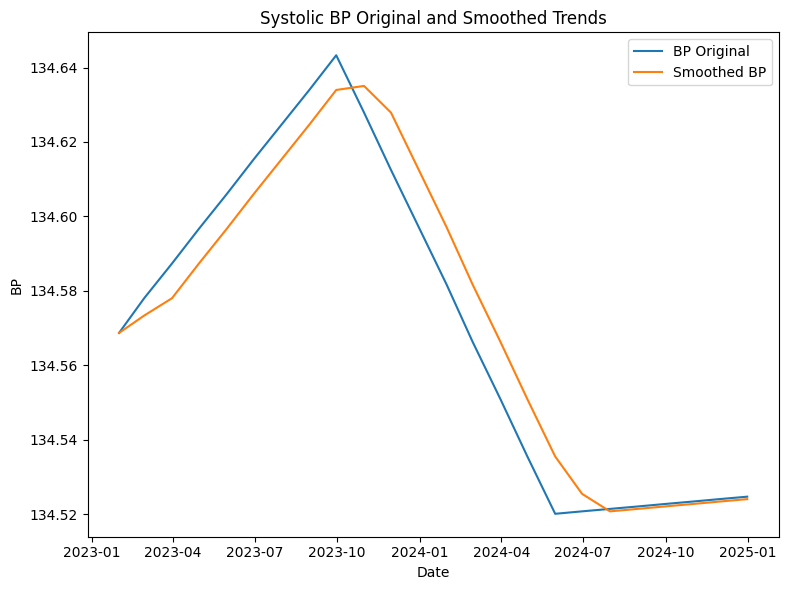

In [19]:
import matplotlib.pyplot as plt
##resample to monthly frequency, with mean aggregation
resampled = ts_bp.resample('ME').mean().interpolate(method='linear')
three_mo_avg = resampled.rolling(window=3, min_periods=1).mean()
ts_bp.ewm(span=3, min_periods=1).mean()
##Visualization before and after calculating moving average
plt.figure(figsize=(8,6))
plt.plot(resampled.index, resampled, label="BP Original")
plt.plot(three_mo_avg.index, three_mo_avg, label="Smoothed BP")
plt.title("Systolic BP Original and Smoothed Trends")
plt.xlabel("Date")
plt.ylabel("BP")
plt.legend()
plt.tight_layout()
plt.show()

## Statistical Modeling Tasks
### Part 1

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        108.4929      1.979     54.812      0.000     104.613     112.372
age            0.2840      0.023     12.219      0.000       0.238       0.330
bmi            0.2786      0.067      4.132      0.000       0.146       0.411
smoking        5.2412      0.681      7.695      0.000       3.906       6.576
diabetes       9.8732      0.728     13.561      0.000       8.446      11.300
const       0.000000e+00
age         2.463951e-34
bmi         3.603054e-05
smoking     1.419603e-14
diabetes    6.865240e-42
dtype: float64
0.37646882997065023


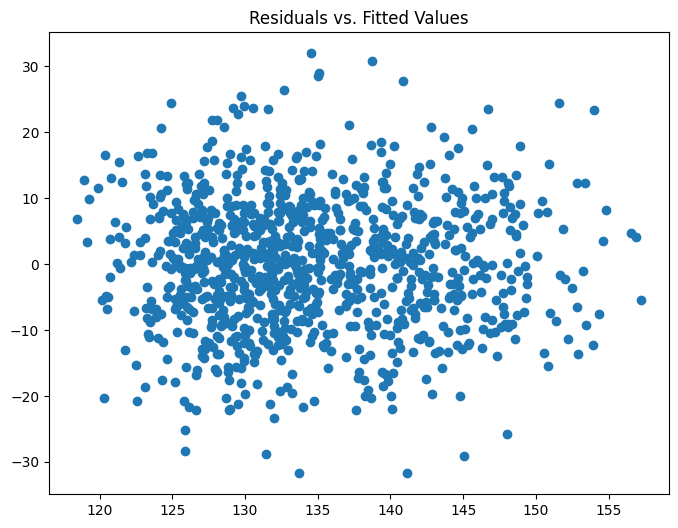

<Figure size 800x600 with 0 Axes>

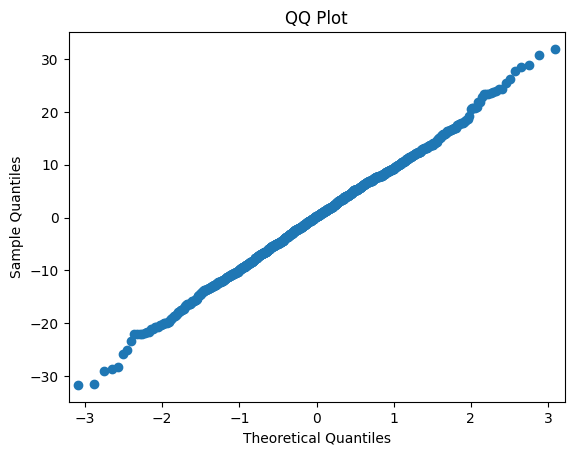

In [8]:
import matplotlib.pyplot as plt
#dependent variable y, blood pressure
y = baseline_dat['bp_systolic']
#independent variable X, containing 4 predictors of interest
X = baseline_dat[['age', 'bmi', 'smoking', 'diabetes']]
#adding constant
X_const = sm.add_constant(X)
#fitting linear regression model
model = sm.OLS(y, X_const).fit(cov_type='HC3')
print(model.summary().tables[1])
print(model.pvalues)
#assessing model fit with R-squared value
print(model.rsquared)
resid_val = model.resid
fitted_val = model.fittedvalues
#making a plot of residuals vs. fitted values
plt.figure(figsize = (8,6))
plt.scatter(fitted_val, resid_val)
plt.title("Residuals vs. Fitted Values")
plt.show()
##QQ plot
plt.figure(figsize = (8,6))
sm.qqplot(resid_val)
plt.title("QQ Plot")
plt.show()

### Interpretation of linear regression model
-The coefficient shows the strength of the association of each predictor with bp values. Diabetes has the largest coefficient, indicating that it is the strongest predictor, while bmi has the lowest coefficient, indicating that it is the weakest predictor of the 4.
-The p-values of 0.000 for all predictors show that the association observed between the 4 variables predicting bp values is not due to random chance

### 2. GLM Model

const        0.127220
age          1.008836
sex          0.920144
bmi          1.000416
smoking      0.784814
diabetes     0.672216
adherence    6.574730
dtype: float64
                  0          1
const      0.033386   0.484780
age        0.999320   1.018442
sex        0.708776   1.194547
bmi        0.972907   1.028702
smoking    0.527452   1.167751
diabetes   0.477052   0.947222
adherence  1.775145  24.351298
1296.0602513141948
1334.774434101428


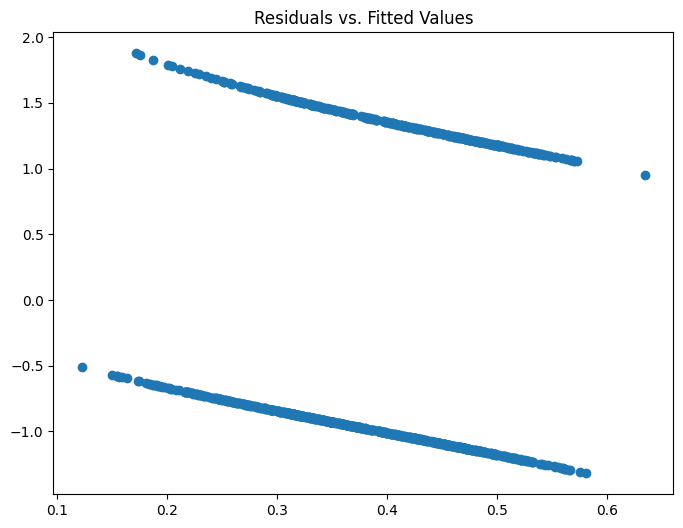

In [17]:
#Creating and fitting a GLM model of binomial family to the treat_dat data, using baseline variables as predictors
y = treat_dat['outcome']
X = treat_dat[['age', 'sex', 'bmi', 'smoking', 'diabetes', 'adherence']]
X_const = sm.add_constant(X)
glm_model = sm.GLM(y, X_const, family=sm.families.Binomial())
glm_results = glm_model.fit()
glm_params = glm_results.params
#calculating the odds ratios & confidence intervals for the model
odds_ratios = np.exp(glm_params)
print(odds_ratios)
ci_odds_r = np.exp(glm_results.conf_int())
print(ci_odds_r)
#checking for influential observations
influence = glm_results.get_influence()
#fig = sm.graphics.plot_regress_exog(glm_results, treat_dat['age'])
#checking residual vs. null deviance to see if the model is a good fit
resid_dev = glm_results.deviance
print(resid_dev)
null_dev = glm_results.null_deviance
print(null_dev)
#diagnostic plotting
resid_glm = glm_results.resid_deviance
fitted_val = glm_results.fittedvalues
plt.figure(figsize = (8,6))
plt.scatter(fitted_val, resid_glm)
plt.title("Residuals vs. Fitted Values")
plt.show()

### Interpretation GLM
-The reduction in value from null deviance to residual deviance shows that the predictors age, sex, bmi, smoking, diabetes, and adherence improve the fit of the GLM
-The pattern of the residuals vs. fitted values diagnostic plot is because we are measuring the treatment outcome, which is binary and is measured as either reaching the treatment goal or not